In [6]:
from osgeo import ogr
import math
import matplotlib.pyplot as plt
import shapely.wkt
from shapely.geometry import Polygon, MultiPolygon
import random

In [50]:
class MWVD:
    def ApoloniusCircle(self, s1, s2, w1, w2, extent):
        """
        Calculates the Apollonius circle for two sites (s1, s2) with weights (w1, w2).

        Args:
            s1: Tuple (x, y) representing the coordinates of the first site.
            s2: Tuple (x, y) representing the coordinates of the second site.
            w1: Weight of the first site.
            w2: Weight of the second site.
            extent: ogr.Geometry representing the extent of the area.

        Returns:
            ogr.Geometry: The Apollonius circle as an ogr.Geometry object.
        """
        if w1 == w2:  # Regular Voronoi (Perpendicular Bisector)
            domBoundary = self._calculate_perpendicular_bisector(s1, s2, extent)
        else:  # Weighted Voronoi (Circle)
            domBoundary = self._calculate_weighted_circle(s1, s2, w1, w2, extent)

        s1_geom = ogr.Geometry(ogr.wkbPoint)
        s1_geom.AddPoint_2D(*s1)

        if s1_geom.Intersects(domBoundary):
            return domBoundary.Intersection(extent)
        else:
            return extent.Difference(domBoundary)

    def _calculate_perpendicular_bisector(self, s1, s2, extent):
        s1x, s1y = s1
        s2x, s2y = s2

        mx = (s1x + s2x) / 2.
        my = (s1y + s2y) / 2.
        dx = s1x - s2x
        dy = s1y - s2y
        d = extent.GetBoundary().Length()
        curve = ogr.Geometry(ogr.wkbLineString)

        if dy != 0:
            m = math.atan(-1. * (dx / dy))
            curve.AddPoint_2D(-d * math.cos(m) + mx, -d * math.sin(m) + my)
            curve.AddPoint_2D(d * math.cos(m) + mx, d * math.sin(m) + my)
        else:
            curve.AddPoint_2D(mx, -d + my)
            curve.AddPoint_2D(mx, d + my)

        shortCurve = curve.Intersection(extent)
        diff = extent.GetBoundary().Difference(curve)
        boundary = diff.GetGeometryRef(1)
        endPoint = boundary.GetPoint(0)
        boundary.AddPoint_2D(endPoint[0], endPoint[1])

        ring = ogr.Geometry(ogr.wkbLinearRing)
        for point in boundary.GetPoints():
            ring.AddPoint_2D(point[0], point[1])
        ring.AddGeometry(boundary)

        domBoundary = ogr.Geometry(ogr.wkbPolygon)
        domBoundary.AddGeometry(ring)

        return domBoundary
        
    def _calculate_weighted_circle(self, s1, s2, w1, w2, extent):
        s1x, s1y = s1
        s2x, s2y = s2

        den = 1.0 / (w1 * w1 - w2 * w2)
        cx = (w1 * w1 * s2x - w2 * w2 * s1x) * den
        cy = (w1 * w1 * s2y - w2 * w2 * s1y) * den
        d = math.sqrt(((s1x - s2x) * (s1x - s2x) + (s1y - s2y) * (s1y - s2y)))
        r = w1 * w2 * d * den
        if r < 0:
            r = r * -1
        # creating the circle boundary from 3 points
        arc = ogr.Geometry(ogr.wkbCircularString)
        arc.AddPoint_2D(cx + r, cy)
        arc.AddPoint_2D(cx, cy + r)
        arc.AddPoint_2D(cx - r, cy)
        arc.AddPoint_2D(cx, cy - r)
        arc.AddPoint_2D(cx + r, cy)
        # creating the circle polygon
        domBoundary = ogr.Geometry(ogr.wkbCurvePolygon)
        domBoundary.AddGeometry(arc)

        return domBoundary

    def getMWVLayer(self, sites, weights, extent):
        """
        Calculates the Multiplicatively Weighted Voronoi Diagram for a set of sites.

        Args:
            sites: List of tuples, each representing a site (x, y): [(x1, y1), (x2, y2), ...].
            weights: List of weights corresponding to the sites: [w1, w2, ...].
            extent: ogr.Geometry representing the extent of the area.

        Returns:
            list: A list of polygons, each represented as an ogr.Geometry object
        """
        polygons = []
        if len(sites) != len(weights):
            raise ValueError("The number of sites and weights must be equal.")

        for i, site1_coords in enumerate(sites):
            site1_weight = weights[i]
            dominance = extent
            for j, site2_coords in enumerate(sites):
                if i != j:
                    site2_weight = weights[j]
                    twoSitesDominance = self.ApoloniusCircle(site1_coords, site2_coords, site1_weight, site2_weight, extent)
                    if twoSitesDominance is not None:
                      dominance = dominance.Intersection(twoSitesDominance)
                    
                    if dominance is None or dominance.IsEmpty():
                        break
            if dominance is not None and not dominance.IsEmpty():
                polygons.append(dominance)

        return polygons

In [51]:
def create_extent(minx, miny, maxx, maxy):
    """
    Creates an extent polygon from given bounds.

    Returns:
        ogr.Geometry: An ogr.Geometry object representing the extent polygon.
    """
    # Create a slightly larger extent for buffering
    dx = (maxx - minx) / 10.
    dy = (maxy - miny) / 10.
    minx -= dx
    miny -= dy
    maxx += dx
    maxy += dy

    ring = ogr.Geometry(ogr.wkbLinearRing)
    ring.AddPoint(minx, miny)
    ring.AddPoint(minx, maxy)
    ring.AddPoint(maxx, maxy)
    ring.AddPoint(maxx, miny)
    ring.AddPoint(minx, miny)

    extent = ogr.Geometry(ogr.wkbPolygon)
    extent.AddGeometry(ring)
    return extent

def create_extent_from_points(points):
    """
    Creates an extent polygon from a list of points.

    Args:
        points: A list of (x, y) tuples representing the points.

    Returns:
        ogr.Geometry: An ogr.Geometry object representing the extent polygon.
    """
    minx = min(p[0] for p in points)
    miny = min(p[1] for p in points)
    maxx = max(p[0] for p in points)
    maxy = max(p[1] for p in points)

    return create_extent(minx, miny, maxx, maxy)

In [55]:
def plot_weighted_voronoi(points, weights, extent=None):
    """
    Generates and plots Multiplicatively Weighted Voronoi Diagrams.

    Args:
        points: A list of tuples representing the (x, y) coordinates of the sites.
        weights: A list of floats representing the weights associated with each site.

    Returns:
        A list of ogr.Geometry objects representing the polygons.
    """
    if not extent:
        extent = create_extent_from_points(points)

    mwvd = MWVD()
    polygons = mwvd.getMWVLayer(points, weights, extent)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Plotting the polygons using Shapely and Matplotlib
    fig, ax = plt.subplots()
    for i, (polygon, site) in enumerate(zip(polygons, points)):
        color = colors[i % len(colors)]
        try:
            # Linearize the polygon to remove curves
            linear_polygon = polygon.GetLinearGeometry()
            
            # Convert ogr.Geometry to Shapely geometry
            shapely_polygon = shapely.wkt.loads(linear_polygon.ExportToWkt())
            shapely_polygon = shapely_polygon.buffer(-0.005) # NOTE helps distinguish sites on boundaries

            # Handle MultiPolygons and Polygons
            if isinstance(shapely_polygon, MultiPolygon):
                for poly in shapely_polygon.geoms:
                    x, y = poly.exterior.xy
                    # Assign color from the list, cycling through if necessary
                    ax.plot(x, y, color=color, linewidth=2)
                    for interior in poly.interiors:
                        x_int, y_int = interior.xy
                        ax.plot(x_int, y_int, color=color, linewidth=2)
            elif isinstance(shapely_polygon, Polygon):
                x, y = shapely_polygon.exterior.xy
                ax.plot(x, y, color=color, linewidth=2)
                for interior in shapely_polygon.interiors:
                    x_int, y_int = interior.xy
                    ax.plot(x_int, y_int, color=color, linewidth=2)

        except Exception as e:
            print(f"Error plotting polygon: {e}")
        
        ax.plot(site[0], site[1], 'o', color=color, markersize=5)
        # ax.text(site[0], site[1], f'{i+1}', fontsize=8, color=color, ha='center', va='center')

    ax.set_aspect('equal')

    plt.show()
    
    return polygons

In [56]:
import numpy as np

def generate_random_floats(min_val, max_val, n, dp=2):
    return [round(num, dp) for num in np.random.uniform(min_val, max_val, n)]

def create_random_points(n, min_val=0.05, max_val=0.95):
    x_coords = generate_random_floats(min_val, max_val, n)
    y_coords = generate_random_floats(min_val, max_val, n)
    return list(zip(x_coords, y_coords))

[(0.88, 0.35), (0.19, 0.14), (0.16, 0.28), (0.41, 0.18), (0.1, 0.52), (0.33, 0.58), (0.54, 0.92), (0.76, 0.58), (0.72, 0.38)]
[1.55, 0.65, 1.31, 0.88, 0.57, 1.58, 1.28, 0.75, 1.34]


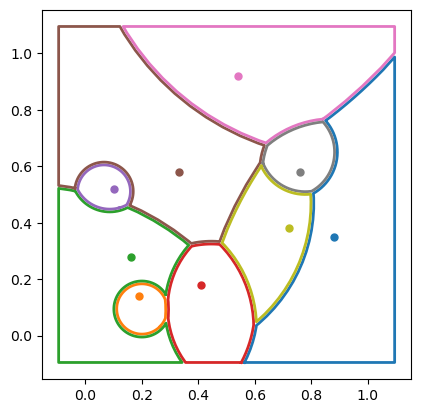

[['CURVEPOLYGON Z (COMPOUNDCURVE Z ((0.58769504665139 -0.020822808191927 0,0.594585088278052 0.005138672575077 0,0.599791200679164 0.031489527416996 0,0.600790469971158 0.039091497350319 0,0.610418980469973 0.046833018548831 0),CIRCULARSTRING Z (0.610418980469973 0.046833018548831 0,0.749038706423533 0.228039233060691 0,0.803399940261357 0.487903183985779 0),(0.803399940261357 0.487903183985779 0,0.802109772098577 0.506642665292193 0,0.803415808177959 0.507317516871325 0),CIRCULARSTRING Z (0.803415808177959 0.507317516871325 0,0.88443555858089 0.620247478807442 0,0.849595403332415 0.75479687434867 0),(0.849595403332415 0.75479687434867 0,0.842888051658153 0.762356217439646 0,0.864539482662764 0.778464942681381 0),CIRCULARSTRING Z (0.864539482662764 0.778464942681381 0,0.96059902 0.85840287 0,1.05061290588009 0.945091999496441 0),(1.05061290588009 0.945091999496441 0,1.1 0.999941924297049 0,1.1 -0.1 0,0.554680708960806 -0.1 0,0.556158922691225 -0.097439658714471 0,0.568065166136464 -0.0

In [58]:
if __name__ == "__main__":
    n = 9
    points = create_random_points(n)
    weights = generate_random_floats(1/2., 2, n)
    
    print(points)
    print(weights)

    # points = [(0.34, 0.15), (0.3, 0.81), (0.15, 0.19), (0.85, 0.26), (0.69, 0.51), (0.93, 0.65), (0.73, 0.83), (0.61, 0.77), (0.79, 0.5)]
    # weights = [1.26, 1.08, 0.73, 1.35, 1.75, 1.06, 1.06, 0.68, 0.91]

    polys = plot_weighted_voronoi(points, weights, create_extent(0, 0, 1, 1))
    print(list([poly.ExportToWkt()] for poly in polys))